In [3]:
#importing all the necessary libraries 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score






In [4]:

# Setup
plt.style.use('ggplot')
nltk.download('vader_lexicon')
nltk.download('stopwords')



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lydia\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lydia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Load FastText-style file
def load_ft_file(file_path):
    texts, labels = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line.startswith('__label__'):
                parts = line.split(' ', 1)
                label = parts[0].replace('__label__', '')
                text = parts[1] if len(parts) > 1 else ''
                labels.append(int(label))
                texts.append(text)
    return pd.DataFrame({'label': labels, 'text': texts})



In [6]:
# Clean text
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()



In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)        # remove punctuation/numbers
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)



In [8]:
# Load & preprocess
df = load_ft_file(r"C:\Users\lydia\OneDrive\Desktop\sentiment analysis\test.ft.txt")
df['label'] = df['label'].apply(lambda x: 1 if x == 2 else 0)  # map to binary
df['cleaned_text'] = df['text'].apply(clean_text)


In [9]:
df.head()

,label,text,cleaned_text
0,1,Great CD: My lovely Pat has one of the GREAT v...,great cd love pat one great voic gener listen ...
1,1,One of the best game music soundtracks - for a...,one best game music soundtrack game didnt real...
2,0,Batteries died within a year ...: I bought thi...,batteri die within year bought charger jul wor...
3,1,"works fine, but Maha Energy is better: Check o...",work fine maha energi better check maha energi...
4,1,Great for the non-audiophile: Reviewed quite a...,great nonaudiophil review quit bit combo playe...


In [10]:
# Limit to subset for speed
subset_df = df.iloc[:10000].copy()


Text(0.5, 1.0, 'Distribution of Labels')

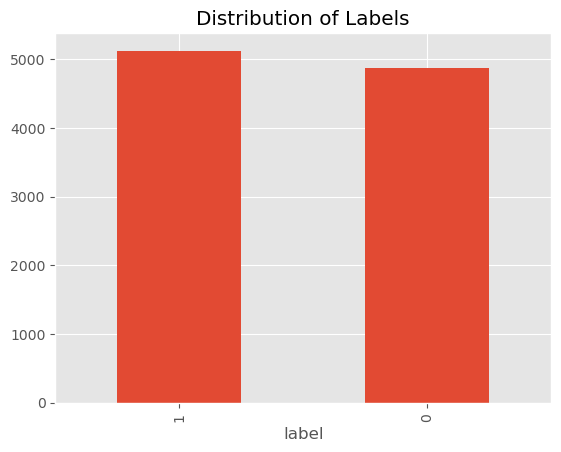

In [11]:
#data analysis 
df["label"].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')

In [12]:

# VADER sentiment
sia = SentimentIntensityAnalyzer()
vader_scores = {}
for i, row in tqdm(subset_df.iterrows(), total=len(subset_df), desc="VADER Analysis"):
    vader_scores[i] = sia.polarity_scores(row['cleaned_text'])
vader_df = pd.DataFrame(vader_scores).T.add_prefix('vader_')

VADER Analysis: 100%|██████████| 9999/9999 [00:02<00:00, 3500.64it/s]


In [13]:
# RoBERTa sentiment
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


In [14]:
def polarity_scores_roberta(text):
    try:
        encoded_text = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        return {
            'roberta_neg': float(scores[0]),
            'roberta_neu': float(scores[1]),
            'roberta_pos': float(scores[2])
        }
    except:
        return {'roberta_neg': np.nan, 'roberta_neu': np.nan, 'roberta_pos': np.nan}




In [15]:
roberta_scores = {}
for i, row in tqdm(subset_df.iterrows(), total=len(subset_df), desc="RoBERTa Analysis"):
    roberta_scores[i] = polarity_scores_roberta(row['cleaned_text'])
roberta_df = pd.DataFrame(roberta_scores).T






RoBERTa Analysis:   0%|          | 0/9999 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
RoBERTa Analysis: 100%|██████████| 9999/9999 [09:27<00:00, 17.62it/s]



In [16]:

# Merge
subset_df = pd.concat([subset_df, vader_df, roberta_df], axis=1)




In [17]:
# Binary prediction from pos/neg
def binary_from_pos_neg(pos, neg):
    return 1 if pos > neg else 0


In [18]:
subset_df['vader_pred'] = subset_df.apply(lambda r: binary_from_pos_neg(r['vader_pos'], r['vader_neg']), axis=1)
subset_df['roberta_pred'] = subset_df.apply(lambda r: binary_from_pos_neg(r['roberta_pos'], r['roberta_neg']), axis=1)



In [21]:
# Evaluation
print("VADER Performance:")
print(classification_report(subset_df['label'], subset_df['vader_pred'], zero_division=0))
print("RoBERTa Performance:")
print(classification_report(subset_df['label'], subset_df['roberta_pred'], zero_division=0))





VADER Performance:
              precision    recall  f1-score   support

           0       0.79      0.42      0.55      4875
           1       0.62      0.89      0.73      5124

    accuracy                           0.66      9999
   macro avg       0.70      0.66      0.64      9999
weighted avg       0.70      0.66      0.64      9999

RoBERTa Performance:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      4875
           1       0.75      0.83      0.79      5124

    accuracy                           0.77      9999
   macro avg       0.77      0.77      0.77      9999
weighted avg       0.77      0.77      0.77      9999



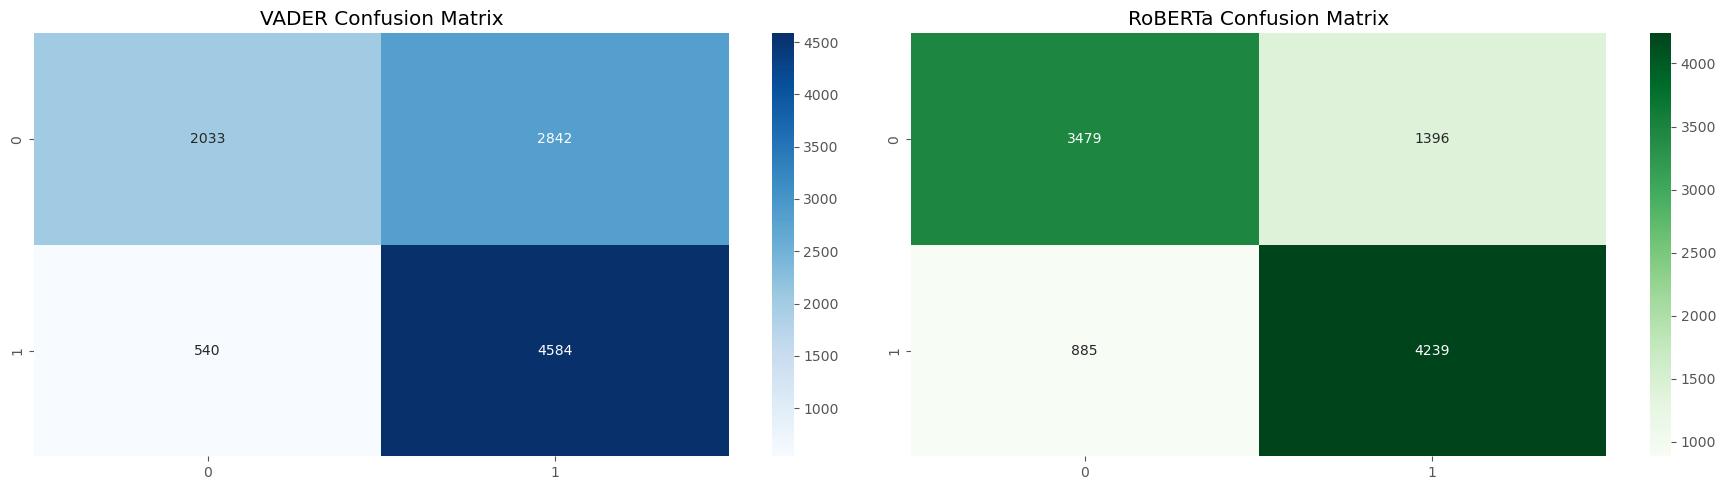

In [20]:
# Confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
sns.heatmap(confusion_matrix(subset_df['label'], subset_df['vader_pred']), annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("VADER Confusion Matrix")
sns.heatmap(confusion_matrix(subset_df['label'], subset_df['roberta_pred']), annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title("RoBERTa Confusion Matrix")
plt.tight_layout()
plt.show()


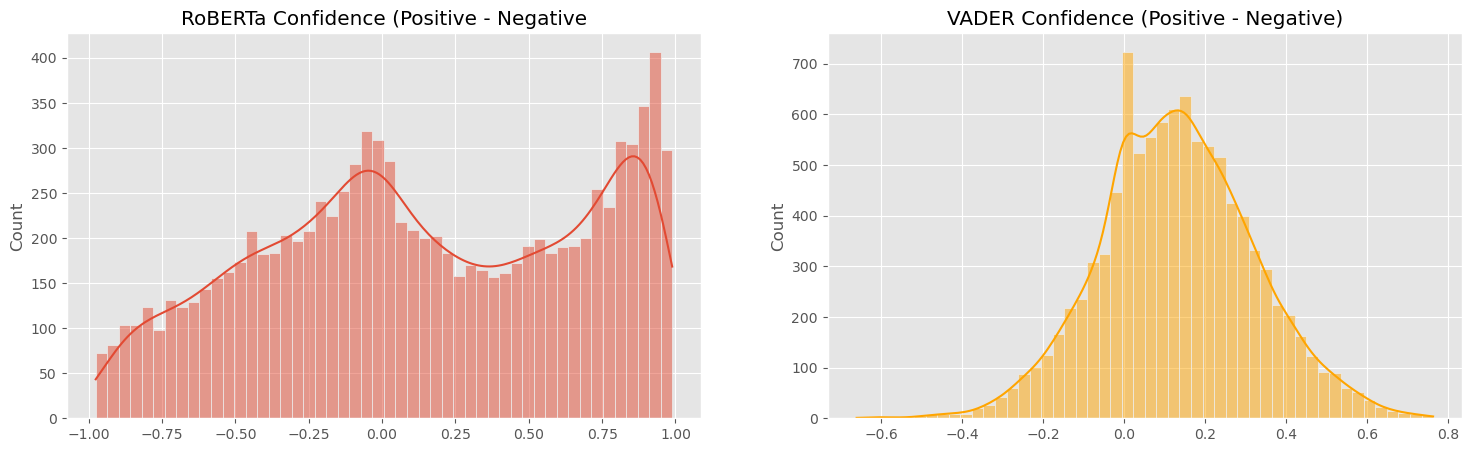

In [33]:

# Confidence visualization
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
sns.histplot(subset_df['roberta_pos'] - subset_df['roberta_neg'], bins=50, kde=True, ax=axs[0])
axs[0].set_title("RoBERTa Confidence (Positive - Negative")
sns.histplot(subset_df['vader_pos'] - subset_df['vader_neg'], bins=50, kde=True, color='orange', ax=axs[1])
axs[1].set_title("VADER Confidence (Positive - Negative)")
plt.show()

In [24]:
# Error clustering
mismatches = subset_df[subset_df['label'] != subset_df['roberta_pred']].copy()
error_features = mismatches[['roberta_pos', 'roberta_neg', 'vader_pos', 'vader_neg']].fillna(0)
kmeans = KMeans(n_clusters=3, random_state=42).fit(error_features)
mismatches['error_cluster'] = kmeans.labels_
print("Error Clusters Distribution:")
print(mismatches['error_cluster'].value_counts())


Error Clusters Distribution:
error_cluster
0    1211
2     665
1     405
Name: count, dtype: int64


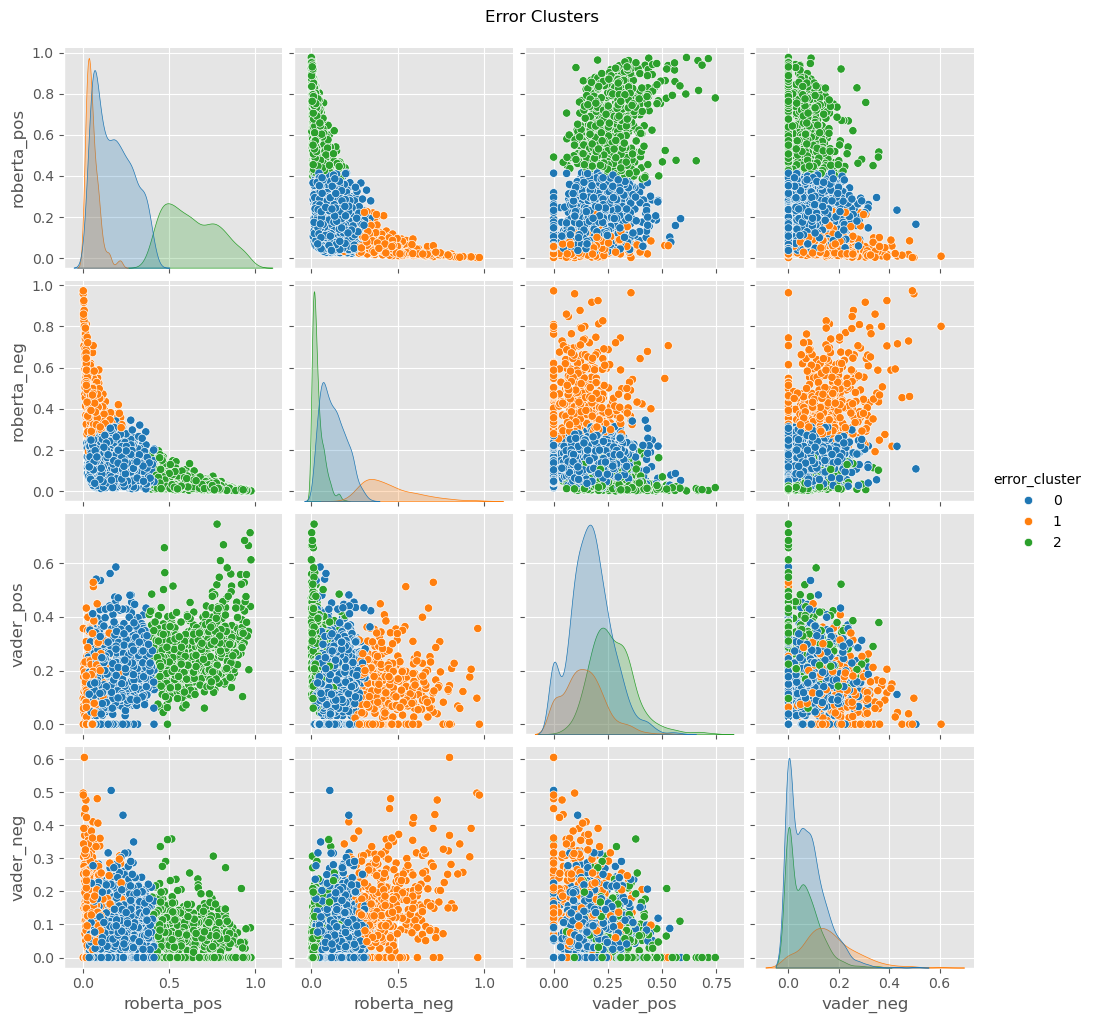

In [25]:
sns.pairplot(mismatches, vars=['roberta_pos', 'roberta_neg', 'vader_pos', 'vader_neg'],
             hue='error_cluster', palette='tab10')
plt.suptitle("Error Clusters", y=1.02)
plt.show()

In [26]:
# Baseline cross-validation with TF-IDF + Logistic Regression
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(subset_df['cleaned_text'])
y = subset_df['label']
log_reg = LogisticRegression(max_iter=1000)
cv_scores = cross_val_score(log_reg, X_tfidf, y, cv=5, scoring='accuracy')
print(f"Baseline Logistic Regression (TF-IDF) CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Baseline Logistic Regression (TF-IDF) CV Accuracy: 0.8477 ± 0.0083


In [28]:
# Error analysis
TOP_N = 5  
# Misclassified examples for each model
vader_misclassified = subset_df[subset_df['label'] != subset_df['vader_pred']].copy()
roberta_misclassified = subset_df[subset_df['label'] != subset_df['roberta_pred']].copy()

# Add confidence scores for sorting
vader_misclassified['confidence'] = abs(vader_misclassified['vader_pos'] - vader_misclassified['vader_neg'])
roberta_misclassified['confidence'] = abs(roberta_misclassified['roberta_pos'] - roberta_misclassified['roberta_neg'])

# Top N most confident wrong predictions
print("\nTop VADER Misclassifications (High Confidence):")
print(vader_misclassified.sort_values(by='confidence', ascending=False)[['text', 'label', 'vader_pred', 'vader_pos', 'vader_neg']].head(TOP_N))

print("\nTop RoBERTa Misclassifications (High Confidence):")
print(roberta_misclassified.sort_values(by='confidence', ascending=False)[['text', 'label', 'roberta_pred', 'roberta_pos', 'roberta_neg']].head(TOP_N))




Top VADER Misclassifications (High Confidence):
                                                   text  label  vader_pred  \
7094  Well..: Well, I have listened to parts of this...      0           1   
5737  an OK album, not great: This was not as good a...      0           1   
9676  Not good: Not worth the money, not worth the o...      0           1   
4986  Relaxing Music?: I was hoping to find some nic...      0           1   
1521  Nice guy and great voice: but I liked him bett...      0           1   

      vader_pos  vader_neg  
7094      0.746        0.0  
5737      0.714        0.0  
9676      0.685        0.0  
4986      0.669        0.0  
1521      0.666        0.0  

Top RoBERTa Misclassifications (High Confidence):
                                                   text  label  roberta_pred  \
7416  Good music: It was a great DVD. But I did real...      0             1   
9006  to all haterz: who ever alblum was lame ur lam...      1             0   
3145  good for a 

In [ ]:
# Compare where VADER and RoBERTa disagree
disagreements = subset_df[subset_df['vader_pred'] != subset_df['roberta_pred']].copy()
print(f"\nNumber of disagreements between VADER and RoBERTa: {len(disagreements)}")
print(disagreements[['text', 'label', 'vader_pred', 'roberta_pred', 'vader_pos', 'vader_neg', 'roberta_pos', 'roberta_neg']].head(TOP_N))


Number of disagreements between VADER and RoBERTa: 2487
                                                 text  label  vader_pred  \
2   Batteries died within a year ...: I bought thi...      0           1   
4   Great for the non-audiophile: Reviewed quite a...      1           1   
7   DVD menu select problems: I cannot scroll thro...      0           1   
12  A complete Bust: This game requires quicktime ...      0           1   
14  didn't run off of USB bus power: Was hoping th...      0           1   

    roberta_pred  vader_pos  vader_neg  roberta_pos  roberta_neg  
2              0      0.251      0.098     0.137649     0.247597  
4              0      0.244      0.025     0.133542     0.311677  
7              0      0.233      0.084     0.015421     0.672187  
12             0      0.079      0.000     0.072652     0.095595  
14             0      0.153      0.000     0.036055     0.346646  
